# Introduction to CVXPY
CVXPY is a Python-embedded modeling language for (disciplined) convex optimization problems.  Much like CVX in MATLAB, it allows you to express the problem in a natural way that follows the math, instead of expressing the problem in a way that conforms to a specific solver's syntax.

  Note: originally written by James Folberth, 2017. Some updates Sept 2018 by Stephen Becker, to work with current cvxpy (ver 1.0) -- not all bugs are fixed though.

[CVXPY Homepage](http://www.cvxpy.org/)

[CVXPY Tutorial Documentation](http://www.cvxpy.org/tutorial/index.html)

[CVXPY Examples](http://www.cvxpy.org/examples/index.html)

In [2]:
import numpy as np # we can use np.array to specify problem data
import matplotlib.pyplot as plt
%matplotlib inline
import cvxpy as cvx

## Example: Least-Squares Curve Fitting



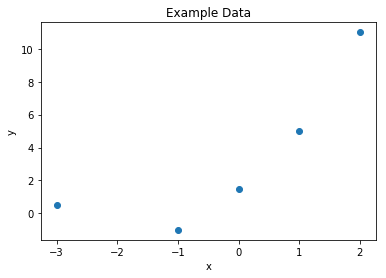

In [3]:
x = np.array([-3,  -1, 0,   1, 2])
y = np.array([0.5, -1, 1.5, 5, 11])
plt.scatter(x,y)
plt.xlabel('x'); plt.ylabel('y'); plt.title('Example Data')
plt.show()

The data look like they follow a quadratic function.  We can set up the following Vandermonde system and use unconstrained least-squares to estimate parameters for a quadratic function.

$$A = \begin{bmatrix}
1 & x_0 & x_0^2\\
1 & x_1 & x_1^2\\
1 & x_2 & x_2^2\\
1 & x_3 & x_3^2\\
1 & x_4 & x_4^2\\
      \end{bmatrix}$$
      
Solving the following least-squares problem for $\beta$ will give us parameters for a quadratic model:

$$\min_\beta \|A\beta - y\|_2$$

Note that we could easily solve this simple problem with a QR factorization (\ in MATLAB, np.linalg.lstsq).

In [4]:
A = np.column_stack((np.ones(5,), x, x**2))

# now setup and solve with CVXPY
beta = cvx.Variable(3)

# CVXPY's norm behaves like np.linalg.norm
obj = cvx.Minimize(cvx.norm(A*beta-y))
prob = cvx.Problem(obj)

# Assuming the problem follows the DCP ruleset,
# CVXPY will select a solver and try to solve the problem.
# We can check if the problem is a disciplined convex program
# with prob.is_dcp().
prob.solve()

print("Problem status: ", prob.status)
print("Optimal value:  ", prob.value)
print("Optimal var:\n", beta.value)

Problem status:  optimal
Optimal value:   0.3496263519482917
Optimal var:
 [1.23858616 3.01656848 0.92157585]


Let's check the solution to see how we did:

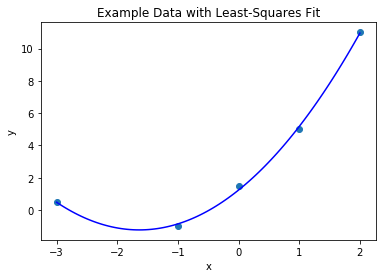

In [8]:
_beta = beta.value # get the optimal vars
_x = np.linspace(x.min(), x.max(), 100)
_y = _beta[0]*np.ones_like(_x) + _beta[1]*_x + _beta[2]*_x**2
plt.scatter(x,y)
plt.plot(_x,_y,'-b')
plt.xlabel('x'); plt.ylabel('y'); plt.title('Example Data with Least-Squares Fit')
plt.show()

## Example: $\ell_1$-norm minimization

Consider the basis pursuit problem

$$\begin{array}{cc} \text{minimize}& \|x\|_1\\\text{subject to} & Ax=y.\end{array}$$

This is a least $\ell_1$-norm problem that will hopefully yield a sparse solution $x$.

We now have an objective, $\|x\|_1$, and an equality constraint $Ax=y$.

In [ ]:
# make a bogus sparse solution and RHS
m = 200; n = 100;
A = np.random.randn(m,n)
_x = np.zeros((n,1))
_k = 10
_I = np.random.permutation(n)[0:_k]
_x[_I] = np.random.randn(_k,1)
y = np.dot(A,_x)

x = cvx.Variable(n)

# Even though the cvx.norm function behaves very similarly to
# the np.linalg.norm function, we CANNOT use the np.linalg.norm 
# function on CVXPY objects.  If we do, we'll probably get a strange
# error message.
obj = cvx.Minimize(cvx.norm(x,1))

# specify a list of constraints
constraints = [ A*x == y ]

# specify and solve the problem
prob = cvx.Problem(obj, constraints)
prob.solve(verbose=True) # let's see the underlying solver's output

print("Problem status: ", prob.status)
print("Optimal value:  ", prob.value)

print("True nonzero inds:      ", sorted(_I))
print("Recovered nonzero inds: ", sorted(np.where(abs(x.value) > 1e-14)[0]))

In [46]:
# make a bogus sparse solution and RHS
m = 200; n = 100;
A = np.random.randn(m,n)
_x = np.zeros((n,1))
_k = 10
_I = np.random.permutation(n)[0:_k]
_x[_I] = np.random.randn(_k,1)
y = np.dot(A,_x)

x = cvx.Variable(n)
obj = cvx.Minimize(cvx.norm(x,1))
prob = cvx.Problem(obj)
#constraints = [ A*x == y ]  # No!! Not unless A is a "matrix" rather than "array" in numpy
constraints = [ A.dot(x) == y ]
prob.solve(verbose=True)

-----------------------------------------------------------------
           OSQP v0.4.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2018
-----------------------------------------------------------------
problem:  variables n = 200, constraints m = 200
          nnz(P) + nnz(A) = 400
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on

iter   objective    pri res    dua res    rho        time
   1  -8.0000e+02   8.00e+00   6.00e-01   1.00e-01   2.34e-04s
  25  -9.4427e-02   9.44e-04   2.81e-06   1.00e-01   4.10e-04s
plsh   1.2504e-29   1.25e-31   0.00e+00   --------   6.27e-04s


/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


1.2504100163934129e-29

## Example: Relaxation of Boolean LP
Consider the Boolean linear program

$$\begin{array}{cl} \text{minimize} & c^Tx\\\text{subject to} & Ax \preceq b\\ & x_i \in\{0,1\}, \quad i=1,...,n.\end{array}$$

Note: the generalized inequality $\preceq$ is just element-wise $\le$ on vectors.

This is not a convex problem, but we can relax it to a linear program and hope that a solution to the relaxed, convex problem is "close" to a solution to the original Boolean LP.  A relaxation of the Boolean LP is the following LP:

$$\begin{array}{cl} \text{minimize} & c^Tx\\\text{subject to} & Ax \preceq b\\ & \mathbf{0} \preceq x \preceq \mathbf{1}.\end{array}$$

The relaxed solution $x^\text{rlx}$ can be used to guess a Boolean point $\hat{x}$ by rounding based on a threshold $t\in[0,1]$:

$$ \hat{x}_i = \left\{\begin{array}{cc} 1 & x_i^\text{rlx} \ge t\\0 & \text{otherwise,}\end{array}\right. $$ 

for $i=1,...,n$.  However, the Boolean point $\hat{x}$ might not satisfy $Ax\preceq b$ (i.e., $\hat{x}$ might be infeasible).

From Boyd and Vandenberghe:
> You can think of $x_i$ as a job we either accept or decline, and $-c_i$ as the (positive) revenue we generate if we accept job $i$.  We can think of $Ax\preceq b$ as a set of limits on $m$ resources.  $A_{ij}$, which is positive, is the amount of resource $i$ consumed if we accept job $j$; $b_i$, which is positive, is the amount of recourse $i$ available.

In [ ]:
m = 300; n = 100;
A = np.random.rand(m,n)
b = A.dot(np.ones((n,1)))/2.
c = -np.random.rand(n,1)

x_rlx = cvx.Variable(n)
obj = cvx.Minimize(c.T*x_rlx)
constraints = [ A*x_rlx <= b,
                0 <= x_rlx, 
                x_rlx <= 1 ]

prob = cvx.Problem(obj, constraints)
prob.solve()

print("Problem status: ", prob.status)
print("Optimal value:  ", prob.value)

plt.hist(x_rlx.value)
plt.xlabel('x_rlx'); plt.ylabel('Count')
plt.title('Histogram of elements of x_rlx')
plt.show()

## Example: Minimum Volume Ellipsoid
Sometimes an example is particularly hard and we might need to adjust solver options, or use a different solver.

Consider the problem of finding the minimum volume ellipsoid (described by the matrix $A$ and vector $b$) that covers a finite set of points $\{x_i\}_{i=1}^n$ in $\mathbb{R}^2$.  The MVE can be found by solving

$$\begin{array}{cl} \text{maximize} & \log(\det(A))\\
\text{subject to} & \|A x_i + b\| \le 1, \quad i=1,...,n.
\end{array}$$

To allow CVXPY to see that the problem conforms to the DCP ruleset, we should use the function `cvx.log_det(A)` instead of something like `log(det(A))`.

In [ ]:
# Generate some data
np.random.seed(271828) # solver='CVXOPT' reaches max_iters
m = 2; n = 50
x = np.random.randn(m,n)

A = cvx.Variable(2,2)
b = cvx.Variable(2)
obj = cvx.Maximize(cvx.log_det(A))
constraints = [ cvx.norm(A*x[:,i] + b) <= 1 for i in range(n) ]

prob = cvx.Problem(obj, constraints)
#prob.solve(solver='CVXOPT', verbose=True) # progress stalls
#prob.solve(solver='CVXOPT', kktsolver='robust', verbose=True) # progress still stalls
prob.solve(solver='SCS', verbose=False) # seems to work, although it's not super accurate

# plot the ellipse and data
angles = np.linspace(0, 2*np.pi, 200)
rhs = np.row_stack((np.cos(angles) - b.value[0], np.sin(angles) - b.value[1]))
ellipse = np.linalg.solve(A.value, rhs)

plt.scatter(x[0,:], x[1,:])
plt.plot(ellipse[0,:].T, ellipse[1,:].T)
plt.xlabel('Dimension 1'); plt.ylabel('Dimension 2')
plt.title('Minimum Volume Ellipsoid')
plt.show()